## This will be the codebase for the dictionary learning portion

### Source Code for sklearn : https://github.com/scikit-learn/scikit-learn

In [67]:
from sklearn.feature_extraction import image as image_extractor
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.decomposition import SparseCoder
from skimage import io
import matplotlib.pyplot as plt
from scipy import ndimage
import csv
import numpy as np
import distutils
from distutils import util
import pdb

In [75]:
"""
First order discretization (linear voting in time)
    events in t,x,y,pol  numpy array
    Assume x and y are integer coordinates
    img_size: for example (180,240) for the DAVIS240C
    num_bins_t: 3-9
"""


def events2voxelgrid_linear(x, y, timestamp, pol, img_size, num_bins_t, t_min, dt_cell, use_polarity=True):
    assert len(x) == len(y) == len(pol) == len(timestamp)
    num_events = len(x)
    # creates a (180,240,5) matrix to store the 5 event frames - each frame will have both positive and negative events
    voxelgrid = np.zeros(img_size+(num_bins_t,), np.float64)
    for i in range(num_events-1):
        tn = (timestamp[i] - t_min) / dt_cell
        ti = int(tn)
        dt = tn - ti
        # Voting on two adjacent cells
        if ti < num_bins_t - 1:
            polarity = (2.*pol[i] - 1.) if use_polarity else 1.
            voxelgrid[y[i], x[i], ti] += (1. - dt)*polarity
        if ti < num_bins_t-2:
            voxelgrid[y[i], x[i], ti+1] += dt*polarity
    print(np.sum(np.abs(voxelgrid)))  # This should equal the number of events
    return voxelgrid.astype('float32')

### Parameters of the method

In [46]:
patch_size = (5, 5)
max_patches = 80000  # Due to memory issues

# Event parameters: the number of events to be taken into consideration
num_time_slices = 5

# Method to compute voxel grids of events (time slices): nearest neighbor or linear voting
method_voting = 'Linear'

# Split by polarity (double grid size) or not?
split_by_polarity = False

# Dictionary
n_components = 1000

### Read the image

In [47]:
image = io.imread("frame_00000561.png",as_gray=True).astype('float32')

Load as grayscale image (because we know that the image has no color), and also convert to floating point, to operate on real numbers, not on integers.

In [48]:
image.shape

(180, 240)

In [49]:
image.dtype

dtype('float32')

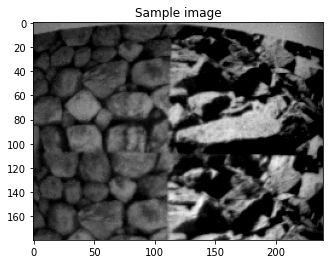

In [50]:
plt.imshow(image, cmap='gray')
plt.title('Sample image')
plt.show()

### Calculate the X and Y derivative using sobel operator. This is very good with edge detection

In [51]:
image_x = ndimage.sobel(image, axis=0).astype('float32')
image_y = ndimage.sobel(image, axis=1).astype('float32')

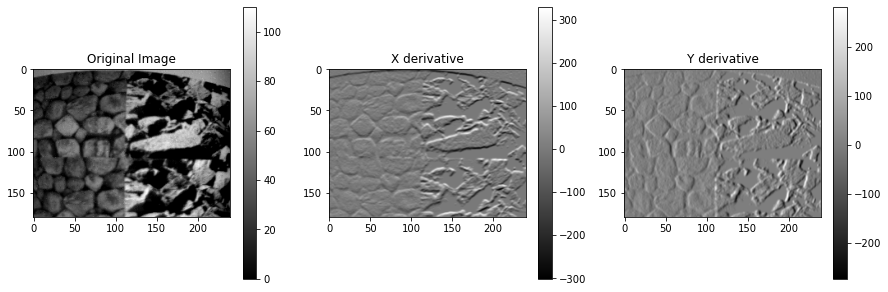

In [52]:
fig, (ax1,ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5), sharex = True)

p1 = ax1.imshow(image, cmap='gray')
ax1.set_title('Original Image')
plt.colorbar(p1,ax=ax1)

p2 = ax2.imshow(image_x, cmap='gray')
ax2.set_title('X derivative')
plt.colorbar(p2,ax=ax2)

p3 = ax3.imshow(image_y, cmap='gray')
ax3.set_title('Y derivative')
plt.colorbar(p3,ax=ax3)

plt.show()

## Create the event histogram

Read events

In [53]:
# read the file and store it in different arrays 
timestamp = []
x = []
y = []
pol = []

with open('event_data12102020.csv') as csvfile:
    event_file = csv.reader(csvfile, delimiter=',')
    next(event_file)
    for row in event_file:
        if len(row) == 0:
            continue; # while writing, an additional alternative empty row is written in the excel. so skippping
        x.append(int(float(row[0])))
        y.append(int(float(row[1])))
        timestamp.append(float(row[2]))
        #pol.append(distutils.util.strtobool(row[3]))
        pol.append(int(float(row[3])))
        
assert len(x) == len(y) == len(pol) == len(timestamp)

In [54]:
total_num_events = len(x)

In [55]:
total_num_events

132886

In [56]:
# convert to arrays
x = np.array(x)
y = np.array(y)
timestamp = np.array(timestamp)
pol = np.array(pol)

In [72]:
timestamp[-1]  - timestamp[0]

0.04999999900000063

In [74]:
timestamp[-2]

24.74567

In [58]:
pol

array([1, 0, 0, ..., 0, 0, 1])

In [59]:
max(x)

239

In [60]:
min(x)

0

In [61]:
max(y)

179

In [62]:
min(y)

0

In [63]:
#dividing the events into equal chunks of time
t_max = np.amax(timestamp)
t_min = np.amin(timestamp)
t_range = t_max - t_min
dt_cell = t_range / num_time_slices
t_edges = np.linspace(t_min,t_max,num_time_slices+1) # boundaries of the cells; not needed

# Specify bin edges in each dimension
bin_edges = (np.linspace(0,image.shape[0],image.shape[0]+1), 
             np.linspace(0,image.shape[1],image.shape[1]+1), t_edges)
print(t_max,t_min,dt_cell)

24.74567 24.695670001 0.009999999800000126


Interpolated histogram
74185.67693809496
(180, 240, 5)


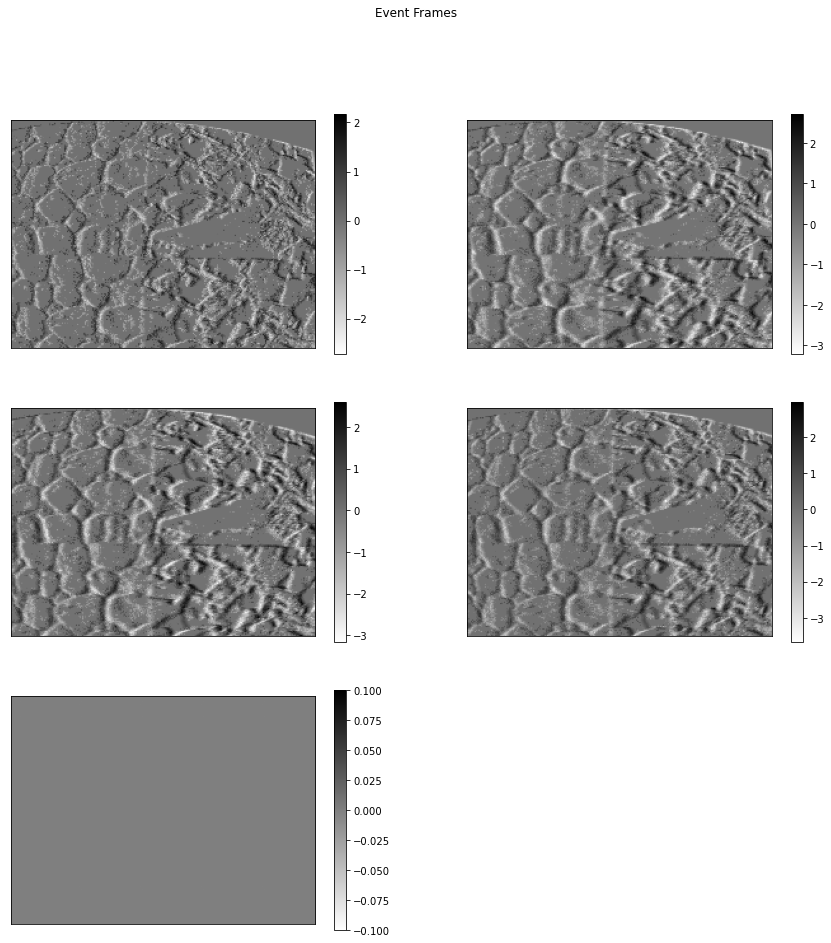

In [76]:
if not split_by_polarity:
    # one voxel grid for all events (both polarities)
    if (method_voting == 'nearest'):
        print('Regular histogram')
        yxt = np.transpose(np.array([y, x, timestamp]))
        voxelgrid, _ = np.histogramdd(yxt, bins=bin_edges).astype('float32')
        del yxt
    else:
        print('Interpolated histogram')
        voxelgrid = events2voxelgrid_linear(x,y,timestamp,pol, 
                                            image.shape,num_time_slices,t_min,dt_cell,use_polarity=True)
    print(voxelgrid.shape)

fig, axs = plt.subplots(3, 2, figsize=(15, 15))
for i in range(voxelgrid.shape[2]):
    plt.sca(axs[int(i/2),i%2])
    plt.imshow(voxelgrid[:,:,i], cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()

axs.flat[-1].set_visible(False)
plt.suptitle("Event Frames")
plt.show()


In [ ]:
if split_by_polarity:
    # Positive events only
    idx_pos = pol==0

    if (method_voting == 'nearest'):
        print('Regular histogram')
        yxt_pos = np.transpose(np.array([y[idx_pos], x[idx_pos], timestamp[idx_pos]]))
        voxelgrid_pos, _ = np.histogramdd(yxt_pos, bins=bin_edges).astype('float32')
        del yxt_pos
    else:
        print('Interpolated histogram')
        voxelgrid_pos = events2voxelgrid_linear(x[idx_pos],y[idx_pos],timestamp[idx_pos],pol[idx_pos], 
                                                image.shape,num_time_slices,t_min,dt_cell,use_polarity=False)
    print(voxelgrid_pos.shape)
    
    fig, axs = plt.subplots(3, 2, figsize=(15, 15))
    for i in range(voxelgrid.shape[2]):
        plt.sca(axs[int(i/2),i%2])
        plt.imshow(voxelgrid_pos[:,:,i], cmap='gray_r')
        plt.xticks([])
        plt.yticks([])
        plt.colorbar()
        
    axs.flat[-1].set_visible(False)
    plt.suptitle("Event Frames")
    plt.show()

In [16]:
if split_by_polarity:
    # Negative events only
    idx_neg = pol!=0

    if (method_voting == 'nearest'):
        print('Regular histogram')
        yxt_neg = np.transpose(np.array([y[idx_neg], x[idx_neg], timestamp[idx_neg]]))
        voxelgrid_neg, _ = np.histogramdd(yxt_neg, bins=bin_edges).astype('float32')
        del yxt_neg
    else:
        print('Interpolated histogram')
        voxelgrid_neg = events2voxelgrid_linear(x[idx_neg],y[idx_neg],timestamp[idx_neg],pol[idx_neg], 
                                                image.shape,num_time_slices,t_min,dt_cell,use_polarity=False)
    print(voxelgrid_neg.shape)
    
    fig, axs = plt.subplots(3, 2, figsize=(15, 15))
    for i in range(voxelgrid.shape[2]):
        plt.sca(axs[int(i/2),i%2])
        plt.imshow(voxelgrid_neg[:,:,i], cmap='gray_r')
        plt.xticks([])
        plt.yticks([])
        plt.colorbar()
        
    axs.flat[-1].set_visible(False)
    plt.suptitle("Event Frames")
    plt.show()

It is a bit more complicated: I think it is better that the chuncks have equal time span $\Delta t$, rather than equal number of events. See the code from Ex 2 in the course to create the voxel grids.

In [17]:
if split_by_polarity:
    fig, axs = plt.subplots(int((num_time_slices+1)/2), 2, figsize=(15, 15))
    fig.suptitle('Histogram of positive events')

    for i in range(num_time_slices):
        plt.sca(axs[int(i/2),i%2])
        plt.imshow(voxelgrid_pos[:,:,i], cmap='gray_r')
        plt.colorbar()

    if num_time_slices % 2 == 1:
        # if odd number of plots, hide last one
        axs.flat[-1].set_visible(False)

    plt.show()

In [18]:
if split_by_polarity:
    fig, axs = plt.subplots(int((num_time_slices+1)/2), 2, figsize=(15, 15))
    fig.suptitle('Histogram of negative events')

    for i in range(num_time_slices):
        plt.sca(axs[int(i/2),i%2])
        plt.imshow(voxelgrid_neg[:,:,i], cmap='gray_r')
        plt.colorbar()

    if num_time_slices % 2 == 1:
        # if odd number of plots, hide last one
        axs.flat[-1].set_visible(False)

    plt.show()

### Combine spatial gradient and temporal derivative (events) to create training patches

Stack the spatial gradient and the temporal derivative (events) on a single WxHxZ array to select the patches together on all Z slices with one single call to `extract_patches_2d`. As we have 5 events and 2 gradients. Z will be 7. W and H will be the image dimension. 

In [19]:
image_gradient = np.concatenate((np.expand_dims(image_x, axis=2), np.expand_dims(image_y, axis=2)), axis=2)
print(image_gradient.shape)
if split_by_polarity:
    voxelgrid = np.concatenate((voxelgrid_pos,voxelgrid_neg), axis=2)
data = np.concatenate((image_gradient, voxelgrid), axis=2)
del image_gradient

(180, 240, 2)


NameError: name 'voxelgrid' is not defined

In [31]:
data.shape

(180, 240, 7)

In [32]:
data.dtype

dtype('float32')

Extract patches

- [X] Check if patches being extracted is correct or not ?

In [33]:
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.image.extract_patches_2d.html
# source code : https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/feature_extraction/image.py
data_patches = image_extractor.extract_patches_2d(data, patch_size, max_patches)
data_patches.shape

C:\Users\sudes\softwares\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass max_patches=80000 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


(41536, 5, 5, 7)

Till here we have extracted all the patches from the 7 layers 

In [34]:
# Plot the information of this patch:
idx_patch = 31

nrm_large = 0
for i in range(int(max_patches/5)):
    # why do this step ?
    ww = data_patches[i].reshape(patch_size[0],patch_size[1],-1)
    nrm = np.linalg.norm(ww)
    if nrm > nrm_large:
        nrm_large = nrm
        idx_patch = i

idx_patch

5074

(5, 5, 7)


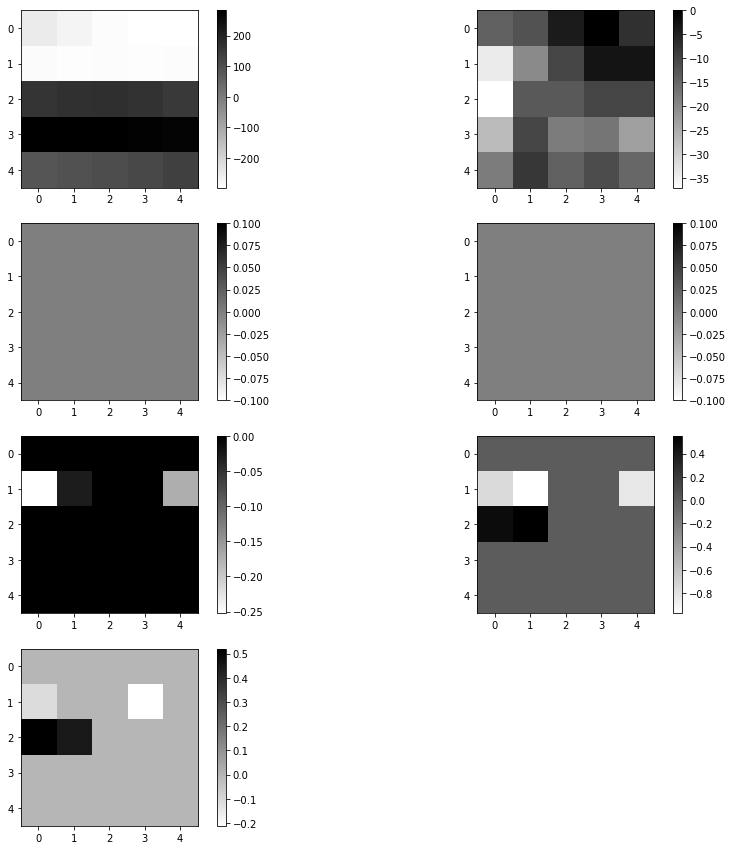

In [35]:
ww = data_patches[idx_patch].reshape(patch_size[0],patch_size[1],-1)
print( ww.shape )
fig, axs = plt.subplots(int((data.shape[2]+1)/2), 2, figsize=(15, 15))
for i in range(data.shape[2]):
    plt.sca(axs[int(i/2),i%2])
    plt.imshow(ww[:,:,i], cmap='gray_r')
    plt.colorbar()
    
if data.shape[2] % 2 == 1:
    # if odd number of plots, hide last one
    axs.flat[-1].set_visible(False)

plt.show()

Prepare (reshape) data for call to dictionary learning function

In [36]:
data_patches = data_patches.reshape(data_patches.shape[0], -1)

In [37]:
data_patches.shape

(41536, 175)

In [38]:
print('Learning the dictionary...')
dico = MiniBatchDictionaryLearning(n_components=n_components, alpha=1, n_iter=500)

Learning the dictionary...


In [39]:
V = dico.fit(data_patches).components_
V.shape

C:\Users\sudes\softwares\Anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 213 iterations, i.e. alpha=8.437e-03, with an active set of 161 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Users\sudes\softwares\Anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 213 iterations, i.e. alpha=8.437e-03, with an active set of 161 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Users\sudes\softwares\Anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 213 iterations, i.e. alpha=8.437e-03, with an active set of 16

C:\Users\sudes\softwares\Anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 43 iterations, i.e. alpha=9.363e-03, with an active set of 35 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Users\sudes\softwares\Anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 44 iterations, i.e. alpha=9.082e-03, with an active set of 36 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Users\sudes\softwares\Anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 46 iterations, i.e. alpha=8.824e-03, with an active set of 38 regr

C:\Users\sudes\softwares\Anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 72 iterations, i.e. alpha=3.882e-02, with an active set of 68 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Users\sudes\softwares\Anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 72 iterations, i.e. alpha=3.882e-02, with an active set of 68 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Users\sudes\softwares\Anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 72 iterations, i.e. alpha=3.882e-02, with an active set of 68 regr

(1000, 175)

Visualize the atoms:

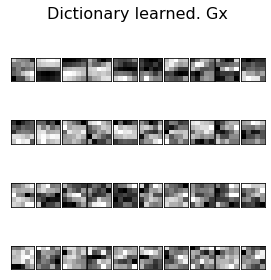

In [40]:
num_atoms_plot = 40
if (num_atoms_plot > n_components):
    num_atoms_plot = n_components

plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(V[:num_atoms_plot]):
    plt.subplot(int(num_atoms_plot/10), 10, i + 1)
    atom = comp.reshape(patch_size[0],patch_size[0],-1)
    plt.imshow(atom[:,:,0], cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('Dictionary learned. Gx\n', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

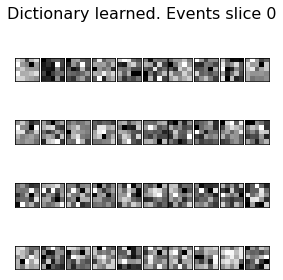

In [41]:
plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(V[:num_atoms_plot]):
    plt.subplot(int(num_atoms_plot/10), 10, i + 1)
    atom = comp.reshape(patch_size[0],patch_size[0],-1)
    plt.imshow(atom[:,:,2], cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('Dictionary learned. Events slice 0\n', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

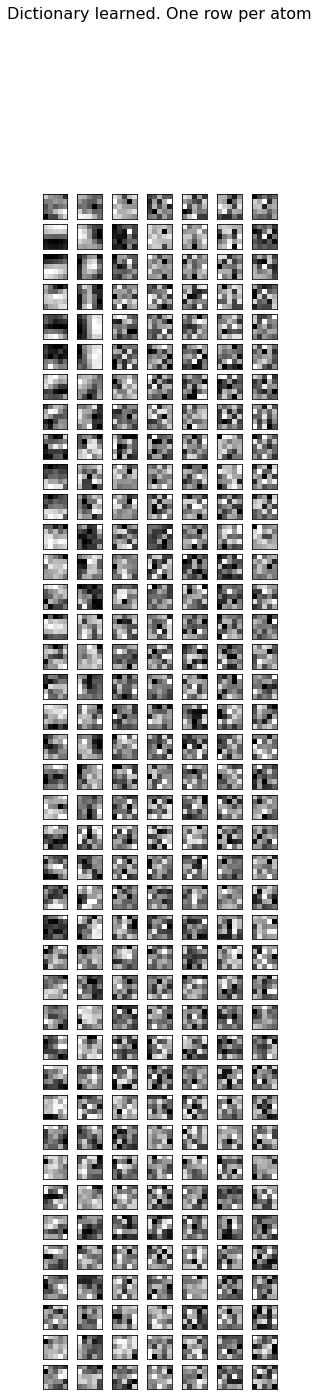

In [42]:
plt.figure(figsize=(4,num_atoms_plot*0.5))
for i, comp in enumerate(V[:num_atoms_plot]):
    atom = comp.reshape(patch_size[0],patch_size[0],-1)
    for j in range(data.shape[2]):
        plt.subplot(num_atoms_plot, data.shape[2], data.shape[2]*i + j + 1)
        plt.imshow(atom[:,:,j], cmap=plt.cm.gray_r, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())
plt.suptitle('Dictionary learned. One row per atom\n', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

Part of the dictionary corresponding to the spatial gradients (the upper part of V)

In [43]:
num_elem_grads = 2*patch_size[0]*patch_size[1]
V_gradients = V[:,:num_elem_grads]
V_gradients.shape

(1000, 50)

Part of the dictionary corresponding to the events (the bottom part of V)

In [44]:
V_events = V[:,num_elem_grads:]
V_events.shape

(1000, 125)

In [45]:
dico

MiniBatchDictionaryLearning(n_components=1000, n_iter=500)

In [46]:
data_test = image_extractor.extract_patches_2d(voxelgrid, patch_size)
data_test.shape

(41536, 5, 5, 5)

In [47]:
data_test = data_test.reshape(data_test.shape[0], -1)
data_test.shape

(41536, 125)

In [48]:
#n_coefs = 10
#coder = SparseCoder(dictionary=V_events, transform_algorithm='omp', transform_n_nonzero_coefs=n_coefs)
coder = SparseCoder(dictionary=V_events, transform_algorithm='omp')

In [49]:
np.transpose(data_test).shape

(125, 41536)

In [50]:
code = coder.transform(data_test)
code.shape

C:\Users\sudes\softwares\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  return f(**kwargs)


(41536, 1000)

In [51]:
patches_g = np.dot(code, V_gradients)
patches_g.shape

(41536, 50)

In [52]:
patches_g = patches_g.reshape(patches_g.shape[0],patch_size[0],patch_size[1],2)
patches_g.shape

(41536, 5, 5, 2)

In [53]:
reconstruction = image_extractor.reconstruct_from_patches_2d(patches_g, (image.shape[0],image.shape[1],2))
reconstruction.shape

(180, 240, 2)

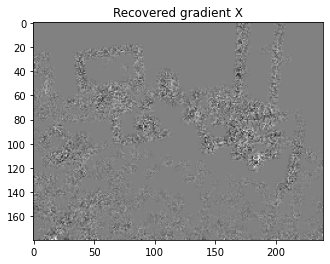

In [54]:
plt.imshow(reconstruction[:,:,0], cmap='gray')
plt.title('Recovered gradient X')
plt.show()

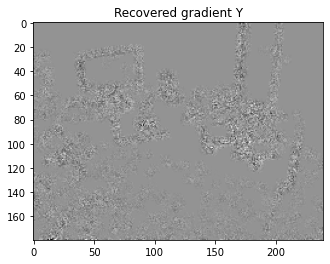

In [55]:
plt.imshow(reconstruction[:,:,1], cmap='gray')
plt.title('Recovered gradient Y')
plt.show()

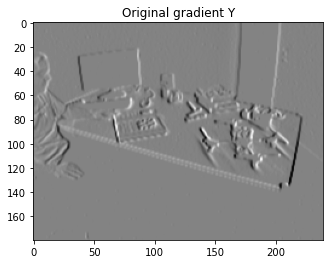

In [56]:
plt.imshow(image_y, cmap='gray')
plt.title('Original gradient Y')
plt.show()

TO DO: 
- [x] compute histograms (Ep,En) using linear voting instead of regular voting
- [x] test with a single voxel grid (with polarity), instead of two (Ep,En)
- [x] better plot the dictionaty. One atom per row
- [x] reconstruction with the learned dictionary
- are gx,gy dominating the largest components? Or are all dimensions independent? Do we need to rescale?
- debug reconstruction. Results do not look good.